# **Notes**
### Purpose: Analogue analysis between two periods for ERA5
#### Also creates the violin plots, similarity and intensity plots


# **Preparation**

In [1]:
import numpy as np # for storing vector and matrix data
import matplotlib.pyplot as plt # to plot figures
import netCDF4 as nc #to read netCDF files
import cartopy.crs as ccrs # to plot maps
# (ergens in test ook: import cartopy as cart)
import cartopy.feature as cf
# from matplotlib import ticker
import scipy.io
from scipy.stats import pearsonr # voor persistence
import scipy.stats as stats
# from cartopy.util import add_cyclic_point
import os
from datetime import datetime, timedelta
from matplotlib.colors import CenteredNorm
from matplotlib.gridspec import GridSpec

# **Functions**

In [2]:
def load_data(path,*variables_to_add):
  """
Provide the path to a file and the variables you want to extract
  """
  data = nc.Dataset(path, mode='r')
  variable_list = []
  for variable in variables_to_add:
    var =data.variables[variable][:]
    variable_list.append(var)
  return variable_list

In [3]:
def extract_area(S, N, W, E, lat, lon, variable,event = False):
    """
    This function slices the data given the S, N, W, E bounds. Use event = True if there are only two dimensions (since then there is no time dimension), this means after using this
    function you need to use event[0] to get the data
    """
    # Change longitude data to go from -180 to 180
    for i in range(len(lon)):
        if lon[i] > 180:
          lon[i] = lon[i] - 360
        else:
          lon[i] = lon[i]

    # Calculate the index of the bounds
    sIndex = np.argmin(np.abs(lat - S))
    nIndex = np.argmin(np.abs(lat - N))
    wIndex = np.argmin(np.abs(lon - W))
    eIndex = np.argmin(np.abs(lon - E))

    if event:
        variable = np.expand_dims(variable, axis = 0)

    if wIndex > eIndex: # If the west index is higher than the east index, think of the right side of the world map as left boundary and vice versa
        latSlice = lat[sIndex: nIndex + 1]
        lonSlice = np.concatenate((lon[wIndex:], lon[:eIndex + 1]))
        variableSlice = np.concatenate((variable[:, sIndex: nIndex + 1, wIndex:], variable[:, sIndex: nIndex + 1, :eIndex + 1]), axis = 2)

    else:
        latSlice = lat[sIndex: nIndex + 1]
        lonSlice = lon[wIndex: eIndex + 1]
        variableSlice = variable[:, sIndex: nIndex + 1, wIndex: eIndex + 1]

    return latSlice, lonSlice, variableSlice

In [4]:
def plot_variablet(lat, lon, variable,folder,name):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "Pressure (Pa)", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [5]:
def lists_for_era5_dates(final_year,final_month,final_day):
    """
    Creates lists with all months and years in the complete ERA5 data, taking into account leap days (schrikkeldagen)
    """
    start_date_all_era5_data = datetime(1950, 1, 1) # Is included
    end_date_all_era5_data = datetime(final_year,final_month,final_day) # Is included
    delta_time = timedelta(days=1)

    date_list_basic = []
    current_date = start_date_all_era5_data
    while current_date <= end_date_all_era5_data:
        date_list_basic.append(current_date)
        current_date += delta_time
    date_strings = [date.strftime('%Y-%m-%d') for date in date_list_basic]
    month_list = [date.month for date in date_list_basic]
    year_list = [date.year for date in date_list_basic]

    return month_list, year_list, date_strings

In [6]:
def extract_years_and_months_era5(era5_data,desired_start_month,desired_end_month,desired_start_year,desired_end_year,list_with_all_months,list_with_all_years):
    """
    Slice era5 data based on the months and years, months and years that are used as input variable will be included as well
    """
    if era5_data.shape[0] != len(list_with_all_months):
        print ("Error: Amount of days in the data and list with all dates are not the same")
    
    list_for_filtered_era5_data = []
    list_for_filtered_years = []
    list_for_filtered_months = []
    for i in range(era5_data.shape[0]):
        month_at_index = list_with_all_months[i]
        year_at_index = list_with_all_years[i]
        if month_at_index >= desired_start_month and month_at_index <= desired_end_month and year_at_index >= desired_start_year and year_at_index <= desired_end_year:
            data_to_select = era5_data[i,:,:]
            list_for_filtered_era5_data.append(data_to_select)
            list_for_filtered_years.append(year_at_index)
            list_for_filtered_months.append(month_at_index)
    array_selected_era5_data = np.array(list_for_filtered_era5_data)

    return array_selected_era5_data, list_for_filtered_years, list_for_filtered_months

In [7]:
def euclidian_distance(data, event):
  """
Calculates the euclidian distance for each day in the data compared to a given single event, gives an array (~list) of all the distances in chronological order
  """
  return np.sqrt(np.sum((data - event)**2, axis = (1, 2)))

In [8]:
def determine_analogues_era5(euclidian_distances, target_number_of_analogues,analogue_seperation_range,list_months,list_years,desired_start_month,desired_end_month,event_is_in_data = True):
  """
  Determine the best analogues. Give an array of all unsorted euclidan distances. The analogue_seperation_range determines how many days have to seperate
  the different analogues (if analogue_seperation_range = 5, the fifth day after an analogue can also still not be a new analogue(dus die dag mag ook niet)).
  Target_number_of_analogues is how many analogues are selected. Returns the indexes of the best analogues in the original data, and the euclidian distances corresponding to the analogues.
  Give semi-filtered data to euclidian_distances: filtered on years but all months, so the seperation range doesn't continue to count in the next season
  Should give semi-filtered lists of months and years as well??
  """
  distance_index_dictionary = {value: index for index, value in enumerate(euclidian_distances)} # Gives the index in the original euclidian distances list for a value in the sorted list
  sorted_distances = np.sort(euclidian_distances) # sort the distances from low to high euclidian distances
  analogues_index_list = [] # create a list to save the indexes of the selected analogues
  euclidian_distance_list = [] # create a list to save the euclidian distances of the selected analogues
  selected_analogue_years = []
  if event_is_in_data == False:
    i = 0
    if sorted_distances[0] == 0:
      print ("WARNING: event does seem to be in data, while event_is_in_data == False (zelf)")
    while len(analogues_index_list) < target_number_of_analogues and (i < len(euclidian_distances)):
      differences= []
      index = distance_index_dictionary[sorted_distances[i]]
      month = list_months[index]
      year = list_years[index]
      if len(analogues_index_list) == 0:
        if month >= desired_start_month and month <= desired_end_month:
          analogues_index_list.append(index)
          euclidian_distance_list.append(sorted_distances[i])
          selected_analogue_years.append(year)
        i = i + 1
      else:
        if month >= desired_start_month and month <= desired_end_month:
          for item in analogues_index_list:
            difference = (index-item)
            if difference < (-1*analogue_seperation_range) or difference > analogue_seperation_range:
              differences.append(2) #goed
            elif difference >= (-1*analogue_seperation_range) and difference <= (analogue_seperation_range):
              differences.append(1) #niet goed
          if min(differences) == 2:
            analogues_index_list.append(index)
            euclidian_distance_list.append(sorted_distances[i])
            selected_analogue_years.append(year)
            i = i + 1
          elif min(differences) == 1:
            i = i + 1
        else:
          i = i + 1

  elif event_is_in_data == True: #Need to make sure the selected analogues are also 5 days away from the event, eventhough it is not a selecgted analogue 
    event_index = distance_index_dictionary[sorted_distances[0]]
    analogues_index_list.append(event_index)
    i=1 #index counter
    if sorted_distances[0] != 0:
      print ("WARNING: event does not seem to be in data, while event_is_in_data == True (zelf)")
    while len(analogues_index_list) < (target_number_of_analogues+1) and (i < len(euclidian_distances)): #+1 omdat event er nu ook in en die later weghalen
      differences= []
      index = distance_index_dictionary[sorted_distances[i]]
      month = list_months[index]
      year = list_years[index]
      if len(analogues_index_list) == 0:
        if month >= desired_start_month and month <= desired_end_month:
          analogues_index_list.append(index)
          euclidian_distance_list.append(sorted_distances[i])
          selected_analogue_years.append(year)
        i = i + 1
      else:
        if month >= desired_start_month and month <= desired_end_month:
          for item in analogues_index_list:
            difference = (index-item)
            if difference < (-1*analogue_seperation_range) or difference > analogue_seperation_range:
              differences.append(2) #goed
            elif difference >= (-1*analogue_seperation_range) and difference <= (analogue_seperation_range):
              differences.append(1) #niet goed
          if min(differences) == 2:
            analogues_index_list.append(index)
            euclidian_distance_list.append(sorted_distances[i])
            selected_analogue_years.append(year)
            i = i + 1
          elif min(differences) == 1:
            i = i + 1
        else:
          i = i + 1
    analogues_index_list.pop(0)

  if len(analogues_index_list) < target_number_of_analogues:
    print ("WARNING: not enough data to find the required amount of analogues (zelf)")
  if len(analogues_index_list) != target_number_of_analogues:
    print ("WARNING: not the right amount of analogues has been found")
  return analogues_index_list,euclidian_distance_list,selected_analogue_years

In [9]:
def determine_analogues_era5_old(euclidian_distances, target_number_of_analogues,analogue_seperation_range,list_months,list_years,desired_start_month,desired_end_month,event_is_in_data = True):
  """
  Determine the best analogues. Give an array of all unsorted euclidan distances. The analogue_seperation_range determines how many days have to seperate
  the different analogues (if analogue_seperation_range = 5, the fifth day after an analogue can also still not be a new analogue(dus die dag mag ook niet)).
  Target_number_of_analogues is how many analogues are selected. Returns the indexes of the best analogues in the original data, and the euclidian distances corresponding to the analogues.
  Give semi-filtered data to euclidian_distances: filtered on years but all months, so the seperation range doesn't continue to count in the next season
  Should give semi-filtered lists of months and years as well??
  """
  distance_index_dictionary = {value: index for index, value in enumerate(euclidian_distances)} # Gives the index in the original euclidian distances list for a value in the sorted list
  sorted_distances = np.sort(euclidian_distances) # sort the distances from low to high euclidian distances
  analogues_index_list = [] # create a list to save the indexes of the selected analogues
  euclidian_distance_list = [] # create a list to save the euclidian distances of the selected analogues
  selected_analogue_years = []
  if event_is_in_data == True:
    i = 1
  elif event_is_in_data == False:
    i=0 #index counter
  while len(analogues_index_list) < target_number_of_analogues and (i < len(euclidian_distances)):
    differences= []
    index = distance_index_dictionary[sorted_distances[i]]
    month = list_months[index]
    year = list_years[index]
    if len(analogues_index_list) == 0:
      if month >= desired_start_month and month <= desired_end_month:
        analogues_index_list.append(index)
        euclidian_distance_list.append(sorted_distances[i])
        selected_analogue_years.append(year)
      i = i + 1
    else:
      if month >= desired_start_month and month <= desired_end_month:
        for item in analogues_index_list:
          difference = (index-item)
          if difference < (-1*analogue_seperation_range) or difference > analogue_seperation_range:
            differences.append(2) #goed
          elif difference >= (-1*analogue_seperation_range) and difference <= (analogue_seperation_range):
            differences.append(1) #niet goed
        if min(differences) == 2:
          analogues_index_list.append(index)
          euclidian_distance_list.append(sorted_distances[i])
          selected_analogue_years.append(year)
          i = i + 1
        elif min(differences) == 1:
          i = i + 1
      else:
        i = i + 1
  if len(analogues_index_list) < target_number_of_analogues:
    print ("WARNING: not enough data to find the required amount of analogues (zelf)")
  return analogues_index_list,euclidian_distance_list,selected_analogue_years

In [10]:
def persistence(analogue_indexes,data,c_threshold):
  """
Defines the persistence of each analogue based on a correlation threshold (>=). It returns a list with a list for each analogue, -1 is a day before the event, 1 is a day after the event.
So if you want the total lenght of the event you still need to add the event itself? (nu wel in lenghts gedaan :) Also returns the correlations in the correct order.
(als je dus de analogues bepaald heb met data gesliced op seizoen die ook hier gebruiken?)
  """
  list_for_lists = [] #
  list_for_lists_values = []
  # nu 500 ook laatste dag dus kan niet vooruit
  for index in analogue_indexes:
    list_for_length = []
    list_for_values = []
    analogue_map = data[index]
    Ab,Ac = np.shape(analogue_map)
    analogue_af = analogue_map.reshape(Ab*Ac)

    index_dag1 = index + 1
    index_dag2 = index - 1
    correlation = 1

    while correlation >= c_threshold and index_dag2 >= 0:
      day_data = data[index_dag2]
      Bb,Bc = np.shape(day_data)
      day_map_af = day_data.reshape(Bb*Bc)
      correlation = pearsonr(analogue_af, day_map_af)[0]
      if correlation >= c_threshold:
        list_for_length.insert(0,-1)
        list_for_values.insert(0,correlation) # dit is met insert dat is anders, dan doet ie het aan de voorkant dus dan staan de values echt op volgorde van de dag.
      index_dag2 = index_dag2 - 1

    correlation = 1

    while correlation >= c_threshold and index_dag1 <= (len(data)-1):
      day_data = data[index_dag1]
      Bb,Bc = np.shape(day_data)
      day_map_af = day_data.reshape(Bb*Bc)
      correlation = pearsonr(analogue_af, day_map_af)[0]
      if correlation >= c_threshold:
        list_for_length.append(1)
        list_for_values.append(correlation)
      index_dag1 = index_dag1 + 1


    list_for_lists.append(list_for_length) # nu dus niet anaologue zelf meegenomen in lengte dus voor lengte nog lengte lijst +1
    list_for_lists_values.append(list_for_values)

  list_for_lengths = []
  for lijst in list_for_lists:
    lengte = len(lijst) + 1
    list_for_lengths.append(lengte)

  return list_for_lists, list_for_lists_values,list_for_lengths

In [11]:
def complete_and_mean_analogue_array(analogue_indexes_p1,data_p1,analogue_indexes_p2,data_p2):
  """
    Gives the array with the data for the analogue and the mean of all the analogues and the difference between the two periods
    the analogue array is sorted op analogue quality (not on time)
  """
  list_for_p1 = []
  list_for_p2 = []

  for index in analogue_indexes_p1:
    data_analogue = data_p1[index]
    list_for_p1.append(data_analogue)

  for index in analogue_indexes_p2:
    data_analogue = data_p2[index]
    list_for_p2.append(data_analogue)

  array_p1 = np.array(list_for_p1) #maak van de list weer een array
  mean_array_p1 = np.mean(array_p1, axis = 0)

  array_p2 = np.array(list_for_p2) #maak van de list weer een array
  mean_array_p2 = np.mean(array_p2, axis = 0)

  difference_between_periods = mean_array_p2 - mean_array_p1
  return difference_between_periods, mean_array_p1, mean_array_p2, array_p1, array_p2, list_for_p1, list_for_p2

In [12]:
def typicality(analogue_distances, analogue_indexes,data,target_number_of_analogues,analogue_seperation_range,list_months,list_years,desired_start_month,desired_end_month,is_event_in_data):
  """
Calculates the Tevent en Tanalogue. Distances need to be from the selected analogues only. Data has to be the one used to calculate the original analogues.
  """
  Tevent = 1/(sum(analogue_distances))
  list_for_Tanalogue = []
  for i in range(len(analogue_indexes)):
    index_in_used_data = analogue_indexes[i]
    euclidian_distance_for_analogue = euclidian_distance(data,data[index_in_used_data])
    index_for_analogues_for_analogue,distance_for_analogues_for_analogue, years_of_analogues_for_analogues = determine_analogues_era5(euclidian_distance_for_analogue, target_number_of_analogues,analogue_seperation_range,list_months,list_years,desired_start_month,desired_end_month,event_is_in_data = True )
    Tanalogue = 1/(sum(distance_for_analogues_for_analogue))
    list_for_Tanalogue.append(Tanalogue)
  return Tevent, list_for_Tanalogue

In [13]:
def violin_plot(Tevent_past,Tevent_present,Tanalogue_past,Tanalogue_present,persistence_past,persistence_present,persistence_event,folder,name):
  """
Doet het? maar stipjes van persistence standaard op 1 want hebt nog niet van event?
  """
  u, p = stats.ttest_ind(Tanalogue_past, Tanalogue_present) #calculate p value
  text_to_plot = f"p = {p:.3f}"

  fig, (ax1,ax2) = plt.subplots(1,2,figsize = (8, 5))
  violins = ax1.violinplot([Tanalogue_past, Tanalogue_present], [1, 1.6], showmeans=False, showextrema=False, showmedians=False)
  colors = ["magenta", "green"]
  for pc, color in zip(violins["bodies"], colors): #pc zijn de violins dus moet zo als verschillende kleuren wil
    pc.set_facecolor(color)
  ax1.axhline(np.mean(Tanalogue_past), color = colors[0], linewidth = 3)
  ax1.axhline(np.mean(Tanalogue_present), color = colors[1], linewidth = 3)
  ax1.plot(1,Tevent_past, marker = "o", color = "r") #plot de events
  ax1.plot(1.6,Tevent_present, marker = "o", color = "r")  #plot de events
  ax1.set_xticks([1, 1.6])
  ax1.set_xticklabels(["Past", "Present"])
  ax1.set_ylim(top = (1.035*(max(max(Tanalogue_past),max(Tanalogue_present))))) # to ensure that the plotted p-value and graph do not overlap
  ax1.text(0.035,0.95,text_to_plot,transform=ax1.transAxes)
  ax1.set_ylabel("Typicality (x$10^{-10}$)")
  ax1.set_title("(A)",loc= "center",fontsize = 11)
  u, p = stats.ttest_ind(persistence_past, persistence_present) #calculate p value
  text_to_plot = f"p = {p:.3f}"


  violins = ax2.violinplot([persistence_past, persistence_present], [1, 1.6], showmeans=False, showextrema=False, showmedians=False)
  colors = ["magenta", "green"]
  for pc, color in zip(violins["bodies"], colors): #pc zijn de violins dus moet zo als verschillende kleuren wil
    pc.set_facecolor(color)
  ax2.axhline(np.mean(persistence_past), color = colors[0], linewidth = 3)
  ax2.axhline(np.mean(persistence_present), color = colors[1], linewidth = 3)
  ax2.plot(1,persistence_event, marker = "o", color = "r") #plot de events
  ax2.plot(1.6,persistence_event, marker = "o", color = "r")  #plot de events
  ax2.set_xticks([1, 1.6])
  ax2.set_xticklabels(["Past", "Present"])
  ax2.set_ylim(top = (1.07*(max(max(persistence_past),max(persistence_present))))) # to ensure that the plotted p-value and graph do not overlap
  ax2.text(0.035,0.95,text_to_plot,transform=ax2.transAxes)
  ax2.set_ylabel("Persistence (days)")
  ax2.set_title("(B)",loc= "center",fontsize = 11)

  plt.subplots_adjust(wspace=0.25)  # Change the value as needed
  #plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/violin2023.png",dpi=600)
  plt.show()
  plt.close()


In [14]:
def t_test(data1850,data1950,p_value):
  """
Performs a two sides t-test, for a analogue difference map data1850 and data1950 should be lists with arrays for each analogue (so not already the mean!), p_value should be for example 0.05
  """
  number_of_analogues = len(data1850)
  significance_mask = data1850[0].copy()
  a, b = np.shape(data1850[0])
  for i in range(a): # for a x
    #print(i)
    for j in range(b): # check every y on that x
      lijst1850 = []
      lijst1950 = []
      for R in range(number_of_analogues): # for each combination of x and y (so each cell) check each analogue
        lijst1850.append(data1850[R][i,j])
        lijst1950.append(data1950[R][i,j])
      #u, p = stats.mannwhitneyu(loc_list1,loc_list2)
      u, p = stats.ttest_ind(lijst1850, lijst1950)
      if p < p_value:
        significance_mask[i,j] = 1
      else:
        significance_mask[i,j] = 0
  return significance_mask

In [15]:
def t_test_trend(data1850,data1950):
  """
Performs a two sides t-test, for a analogue difference map data1850 and data1950 should be lists with arrays for each analogue (so not already the mean!), p_value should be for example 0.05
  """
  u, p = stats.ttest_ind(data1850, data1950)
  print (p)

In [16]:
def plot_differencet(lat, lon, variable,significance_mask,folder,name):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.contourf( lon, lat,significance_mask, levels=[-2,0,2], hatches=[None, '////'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "Pressure (Pa)", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [17]:
def plot_differencet_centeredt(lat, lon, variable,significance_mask,folder,name):
    plt.figure(figsize = (10,10))
    ax = plt.axes(projection = ccrs.PlateCarree())
    plot = plt.contourf(lon, lat, variable, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = 15, norm = CenteredNorm()) #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
    ax.contourf( lon, lat,significance_mask, levels=[-2,0,2], hatches=[None, '////'], colors='none', transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cf.BORDERS)
    plt.colorbar(plot, ax=ax, orientation = "horizontal", label = "Streamfunction (m²/s)", pad = 0.05)
    #plt.savefig(f"{folder}/{name}.png",dpi=300)
    plt.show()
    plt.close()

In [18]:
def yearly_minimum_euclidian_distance(euclidian_distances, yearlength = 360):
  """
Finds the best analogue (lowest ecleudian distance) for each year to do trend analysis. Returns an array with the distances.
  """
  distances_per_year = euclidian_distances.reshape((euclidian_distances.shape[0] // yearlength, yearlength))
  return np.min(distances_per_year, axis = 1) #loopt blijkbaar al automatisch door alle jaren

In [19]:
def yearly_minimum_euclidian_distance2(euclidian_distances,yearlength,year_of_event,start_year, event_is_in_data):
  """
Finds the best analogue (lowest ecleudian distance) for each year to do trend analysis. Returns an array with the distances.
  """
  distances_per_year = euclidian_distances.reshape((euclidian_distances.shape[0] // yearlength, yearlength))
  if event_is_in_data == False:
    return np.min(distances_per_year, axis = 1) #loopt blijkbaar al automatisch door alle jaren
  elif event_is_in_data == True:
    list_for_minimums = []
    for i in range(distances_per_year.shape[0]):
      yearly_data = distances_per_year[i,:]
      year = start_year + i
      if year == year_of_event:
        sorted_data = np.sort(yearly_data)
        min_distance = sorted_data[1]
        list_for_minimums.append(min_distance)
      else:
        min_distance = np.min(yearly_data)
        list_for_minimums.append(min_distance)
    array_min_distances = np.array(list_for_minimums)
    return array_min_distances

In [20]:
def plot_trend(yearly_min_distance,distances, start_year, end_year, folder, name,running_mean_window = 1):
  """
Moet wel goed checken dat length x_ticks and y_data hetzelfde is (dus 100 years, is 1850 tot en met 1949! dus ook end_year = 1949)
  """
  plt.figure(figsize = (10,8))
  max_distance = max(distances)
  y_data = 1 - (yearly_min_distance/max_distance) # loopt ook somehow al door alle distances
  running_mean = np.convolve(y_data, np.ones(running_mean_window) / running_mean_window, mode = "valid") #valid is dat rand niet doet (kan wel met 'same' maar dan voegt die nullen toe dus dan average fout,). Kernel (2e input) is weight voor verschillende plekken in window (hier overal gelijk?)
  x_ticks = range(start_year, end_year + 1)
  plt.ylabel("1 - (ED/EDmax)")
  plt.xlabel("Years")

  plt.plot(x_ticks,y_data)
  if running_mean_window != 1:
    plt.plot(range(start_year + (running_mean_window // 2 - 1), end_year - (running_mean_window // 2 - 1)),running_mean) #begin van bram, omdat eerste paar jaar niet window kan doen
  #plt.savefig(f"{folder}/{name}.png",dpi=300)
  plt.show()
  plt.close()

  return y_data, running_mean

In [21]:
def plot_trend2(yearly_min_distance,distances, start_year, end_year,max_euclidian_distance, folder, name,running_mean_window = 1):
  """
Moet wel goed checken dat length x_ticks and y_data hetzelfde is (dus 100 years, is 1850 tot en met 1949! dus ook end_year = 1949)
  """
  plt.figure(figsize = (10,8))
  max_distance = max_euclidian_distance
  y_data = 1 - (yearly_min_distance/max_distance) # loopt ook somehow al door alle distances
  running_mean = np.convolve(y_data, np.ones(running_mean_window) / running_mean_window, mode = "valid") #valid is dat rand niet doet (kan wel met 'same' maar dan voegt die nullen toe dus dan average fout,). Kernel (2e input) is weight voor verschillende plekken in window (hier overal gelijk?)
  x_ticks = range(start_year, end_year + 1)
  plt.ylabel("1 - (ED/EDmax)")
  plt.xlabel("Years")

  plt.plot(x_ticks,y_data)
  if running_mean_window != 1:
    plt.plot(range(start_year + (running_mean_window // 2 - 1), end_year - (running_mean_window // 2 - 1)),running_mean) #begin van bram, omdat eerste paar jaar niet window kan doen
  #plt.savefig(f"{folder}/{name}.png",dpi=300)
  plt.show()
  plt.close()

  return y_data, running_mean

In [22]:
def plot_trend_combined_subplots(y_data_p1,y_data_p2,running_mean_data_p1,running_mean_data_p2, start_year1850,start_year1950, end_year1850,end_year1950, folder, name,running_mean_window = 1):
  """
  Moet wel goed checken dat length x_ticks and y_data hetzelfde is (dus 100 years, is 1850 tot en met 1949! dus ook end_year = 1949)
  """
  fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2,figsize = (10,4), sharey = True)
  x_ticks1 = range(start_year1850, end_year1850 + 1)
  x_ticks2 = range(start_year1950, end_year1950 + 1)
  ax1.set_ylabel("1 - (ED/EDmax)")
  ax1.set_xlabel("Years")
  ax2.set_xlabel("Years")
  
  ax1.plot(x_ticks1,y_data_p1, c = "darkturquoise") #linewidth = 2
  if running_mean_window != 1:
    ax1.plot(range(start_year1850 + (running_mean_window // 2 - 1), end_year1850 - (running_mean_window // 2 - 1)),running_mean_data_p1, c = "black") #begin van bram, omdat eerste paar jaar niet window kan doen
  ax2.plot(x_ticks2,y_data_p2, c = "darkturquoise") #linewidth = 2
  if running_mean_window != 1:
    ax2.plot(range(start_year1950 + (running_mean_window // 2 - 1), end_year1950 - (running_mean_window // 2 - 1)),running_mean_data_p2, c = "black") #begin van bram, omdat eerste paar jaar niet window kan doen
  plt.subplots_adjust(wspace=0.1) # Adjust the horizontal space between the two plot (in percentage compared to the average axis-length?)
  #plt.savefig(f"{folder}/{name}.png",dpi=300)
  plt.show()
  plt.close()

In [23]:
def plot_trend_combined_subplots2(y_data_p1,y_data_p2,running_mean_data_p1,running_mean_data_p2, start_year1850,start_year1950, end_year1850,end_year1950, folder, name,running_mean_window = 1):
  """
  Moet wel goed checken dat length x_ticks and y_data hetzelfde is (dus 100 years, is 1850 tot en met 1949! dus ook end_year = 1949)
  """
  fig, (ax1,ax2) = plt.subplots(nrows = 1, ncols = 2,figsize = (10,4), sharey = True)
  x_ticks1 = range(start_year1850, end_year1850 + 1)
  x_ticks2 = range(start_year1950, end_year1950 + 1)
  ax1.set_ylabel("Similarity")
  ax1.set_xlabel("Years")
  ax2.set_xlabel("Years")
  
  ax1.plot(x_ticks1,y_data_p1, c = "darkturquoise") #linewidth = 2
  mean1 = np.mean(y_data_p1)
  ax1.axhline(y = mean1, c = "grey", linestyle = "--") #begin van bram, omdat eerste paar jaar niet window kan doen
  ax2.plot(x_ticks2,y_data_p2, c = "darkturquoise") #linewidth = 2
  mean2 = np.mean(y_data_p2)
  ax2.axhline(y = mean2, c = "grey", linestyle = "--")
  plt.subplots_adjust(wspace=0.1) # Adjust the horizontal space between the two plot (in percentage compared to the average axis-length?)
  #plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/trend2023_p_0.09508_label.png",dpi=600)
  plt.show()
  plt.close()

In [24]:
def prep_streamfunction(data):
    """
    doen nadat bijgesneden
    """
    list_for_new_data = []
    for i in range(data.shape[0]):
        data_day = data[i,:,:]
        day_mean = np.mean(data_day)
        new_data = data_day - day_mean
        list_for_new_data.append(new_data)
    new_array = np.array(list_for_new_data)
    
    return new_array

In [25]:
def find_max_for_trend(distances_p1,distances_p2):
    max1 = np.max(distances_p1)
    max2 = np.max(distances_p2)
    if max1 > max2:
        return max1
    elif max2 > max1:
        return max2
    else:
        print ("WARNING, something went wrong in determining the max distance for the trend plot (zelf)")

# **Set-up**

In [26]:
#Select: "regridded" or "original", Als original data doet hebt kans dat kleiner gebied moet doen want doet EU data en dat data geupdate is dus dat lijst langer moet zijn met dates
data_to_use = "regridded"

In [27]:
#Define the path where the data is located
if data_to_use == "regridded":
    #data_path_msl = "/net/pc200246/nobackup/users/noest/ERA5_regridded/era5_psi500_daily_regridded.nc"
    data_path_msl = "/net/pc200246/nobackup/users/noest/ERA5_regridded/era5_psi500_daily_regridded_1950_2023.nc"
    data_path_pressure = "/net/pc200246/nobackup/users/noest/ERA5_regridded/era5_msl_daily_regridded.nc"
elif data_to_use == "original":
    data_path_msl = "/net/pc200265/nobackup/users/pinto/phi500/era5_phi500.fixed.1degE.nc"

In [28]:
#Define the path where the event is located (path to actual file), for the Vautard event: its downloaded using the global data so also use the global data to make sure the resolution is the same
if data_to_use == "regridded":
    event_path = "/usr/people/noest/stage_folders/event_data/Vautard_southerlyflow_2019-06-29_regridded_streamfunction_data_at_index_25381.npy"
elif data_to_use == "original":
    event_path = '/usr/people/noest/stage_folders/event_data/Vautard_southerlyflow_2019-06-29_original_streamfunction_data_at_index_25381.npy'

In [29]:
#Select the area to be analysed (for original is lat omgedraaid, iig extent eu data (gebruikt niet hier): lat (29.875-75.125) en lon(-30.125-40.125))
bbox = [30,60,-30,20] #Pick borders like: [S,N,W,E]

In [30]:
#The latest date in the ERA5 dataset, for the regridded data its 2024, 2, 29
final_yearV = 2024
final_monthV = 2
final_dayV = 29

In [31]:
#Select the months and years that will be analysed for period 1 (V1) and period 2 (V2)
desired_start_monthV1 = 3 # 6 voor JJA en 3 voor MAM
desired_end_monthV1 = 5 # 8 voor JJA en 5 voor MAM
desired_start_yearV1 = 1950 # 1950 for all data
desired_end_yearV1 = 1979 # 2014 for model comparison, 2023 is the last complete year
desired_start_monthV2 = 3 # 6 voor JJA en 3 voor MAM
desired_end_monthV2 = 5 # 8 voor JJA en 5 voor MAM
desired_start_yearV2 = 1994 # 1950 for all data
desired_end_yearV2 = 2023 # 2014 for model comparison, 2023 is the last complete year

In [32]:
#Determine how to look for analogues
target_number_of_analoguesV = 30 # How many analogues to find
analogue_seperation_rangeV = 6 # How many days should the analogues be seperated by
event_is_in_dataV1 = False # Is the event in the filtered data? (For example, if event is in 2019, and period 1 is 1950-1979, than = False)(doet hierbij wel semi-filtered data? dus denk ook als kijkt naar spring en event in summer toch true? nee want voegt alleen analogue toe als ook goede maand?)
event_is_in_dataV2 = False

In [33]:
#Determine how to calculate the persistence (the minimum correlation coefficient a day needs in order to be taken into account as the same event)
correlation_thresholdV = 0.9

In [34]:
#Set the year in which the event takes place to calculate the persistence of the event
event_year = 2019

In [35]:
#Set the p value for the significance in the difference plots
p_value_difference_mapsV = 0.05 

In [36]:
#Set the filtered yearlenght and running mean window for the trend plot
filterd_yearlengthV = 92 # 92 voor JJA en MAM
running_mean_windowV = 10 # If this = 1, no running mean window is plotted
event_is_in_data_trendV1 = False # Is the event in the filtered data? (For example, if event is in 2019, and period 1 is 1950-1979, than = False)(Bij deze wel op seizoen letten! dus als kijkt naar spring en event in summer = False want gebruikt season data for euclidian distance)
event_is_in_data_trendV2 = False

In [37]:
#Determine the amount of analogue plots to save for each period
amount_of_analogues_to_plot = 2

In [38]:
#Determine which arrays to save

# **Uitvoeren**

In [39]:
#Load data
lat_global,lon_global,msl_levels = load_data(data_path_msl,"lat","lon","stream")
msl_global = np.squeeze(msl_levels)

In [40]:
#Load event
event_msl_global = np.load(event_path)

In [41]:
#Determine the boundaries to use
if data_to_use == "regridded":
    S1 = bbox[0] # for serious_run1 = 30 en 70 als data_to_use = "original"
    N1 = bbox[1] # for serious_run1 = 70 en 30 als data_to_use = "original"
    W1 = bbox[2] # for serious_run1 = -30
    E1 = bbox[3] # for serious_run1 = 30
elif data_to_use == "original":
    S1 = bbox[1] # for serious_run1 = 30 en 70 als data_to_use = "original"
    N1 = bbox[0] # for serious_run1 = 70 en 30 als data_to_use = "original"
    W1 = bbox[2] # for serious_run1 = -30
    E1 = bbox[3] # for serious_run1 = 30

In [42]:
#Extract area
lat_box, lon_box, msl_box_og = extract_area(S1,N1,W1,E1,lat_global,lon_global,msl_global, event = False)
msl_box = prep_streamfunction(msl_box_og)

In [43]:
#Extract areaa
lat_box2, lon_box2, event_box_og = extract_area(S1,N1,W1,E1,lat_global,lon_global,event_msl_global, event = True)
event_box = prep_streamfunction(event_box_og)

In [44]:
#Create lists with the months, years and complete dates of the era5 data
list_with_months, list_with_years, list_with_dates = lists_for_era5_dates(final_yearV,final_monthV,final_dayV)

In [45]:
#Extract the periods and the seasons, semi_filtered is all months so the index for the analogue_seperation_range doesn't continue between years
msl_box_semi_filtered_p1,filtered_years_list_p1,filtered_months_list_p1 = extract_years_and_months_era5(msl_box,1,12,desired_start_yearV1,desired_end_yearV1,list_with_months, list_with_years)
msl_box_semi_filtered_p2,filtered_years_list_p2,filtered_months_list_p2 = extract_years_and_months_era5(msl_box,1,12,desired_start_yearV2,desired_end_yearV2,list_with_months, list_with_years)

Error: Amount of days in the data and list with all dates are not the same
Error: Amount of days in the data and list with all dates are not the same


In [46]:
#Calculate euclidian distances
euclidian_distance_p1 = euclidian_distance(msl_box_semi_filtered_p1,event_box)
euclidian_distance_p2 = euclidian_distance(msl_box_semi_filtered_p2,event_box)

In [47]:
#Find analogues
analogues_index_list_p1,euclidian_distance_list_p1,selected_analogue_years_p1 = determine_analogues_era5(euclidian_distance_p1, target_number_of_analoguesV,analogue_seperation_rangeV,filtered_months_list_p1,filtered_years_list_p1,desired_start_monthV1,desired_end_monthV1,event_is_in_data = event_is_in_dataV1)
analogues_index_list_p2,euclidian_distance_list_p2,selected_analogue_years_p2 = determine_analogues_era5(euclidian_distance_p2, target_number_of_analoguesV,analogue_seperation_rangeV,filtered_months_list_p2,filtered_years_list_p2,desired_start_monthV2,desired_end_monthV2,event_is_in_data = event_is_in_dataV2)

In [48]:
print (min(euclidian_distance_list_p1))

124646264.0


In [49]:
#Find persistence (use the same data that was used as for the euclidian distances)
persistence_days_p1, persistence_correlations_p1, lengths_p1 = persistence(analogues_index_list_p1,msl_box_semi_filtered_p1,correlation_thresholdV)
persistence_days_p2, persistence_correlations_p2, lengths_p2 = persistence(analogues_index_list_p2,msl_box_semi_filtered_p2,correlation_thresholdV)

In [50]:
#Calculate the difference between periods, the mean analogue arrays and the arrays with all analogues
pressure_difference_between_periods, mean_analogue_array_p1, mean_analogue_array_p2, analogues_array_p1, analogues_array_p2, analogues_list_p1, analogues_list_p2 = complete_and_mean_analogue_array(analogues_index_list_p1,msl_box_semi_filtered_p1,analogues_index_list_p2,msl_box_semi_filtered_p2)

In [1]:
#Plot the analogue maps
# for i in range(amount_of_analogues_to_plot):
#     analogue_to_plot_p1 = analogues_array_p1[i,:,:]
#     analogue_to_plot_p2 = analogues_array_p2[i,:,:]
#     plot_variablet(lat_box,lon_box,analogue_to_plot_p1,"test","test")
#     plot_variablet(lat_box,lon_box,analogue_to_plot_p2,"test","test")

In [52]:
#Calculate typicalities
Tevent_p1, Tanalogue_p1 = typicality(euclidian_distance_list_p1,analogues_index_list_p1,msl_box_semi_filtered_p1,target_number_of_analoguesV,analogue_seperation_rangeV,filtered_months_list_p1,filtered_years_list_p1,desired_start_monthV1,desired_end_monthV1, event_is_in_dataV1)
Tevent_p2, Tanalogue_p2 = typicality(euclidian_distance_list_p2,analogues_index_list_p2,msl_box_semi_filtered_p2,target_number_of_analoguesV,analogue_seperation_rangeV,filtered_months_list_p2,filtered_years_list_p2,desired_start_monthV2,desired_end_monthV2, event_is_in_dataV2)

In [53]:
#Find the persistence of the event
year_event_min = event_year - 1
year_event_max = event_year + 1
msl_box_semi_filtered_event,filtered_years_list_event,filtered_months_list_event = extract_years_and_months_era5(msl_box,1,12,year_event_min,year_event_max,list_with_months, list_with_years)
euclidian_distance_event = euclidian_distance(msl_box_semi_filtered_event,event_box)
analogues_index_list_event,euclidian_distance_list_event,selected_analogue_years_event = determine_analogues_era5(euclidian_distance_event, 1,analogue_seperation_rangeV,filtered_months_list_event,filtered_years_list_event,1,12,event_is_in_data = False)
persistence_days_event, persistence_correlations_event, lengths_event = persistence(analogues_index_list_event,msl_box_semi_filtered_event,correlation_thresholdV)

Error: Amount of days in the data and list with all dates are not the same


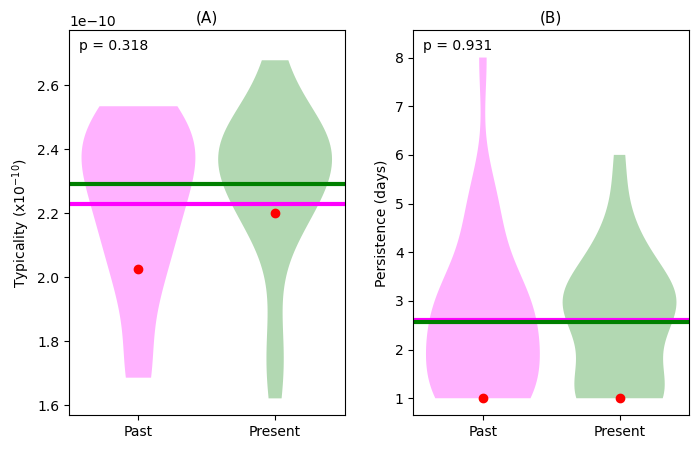

In [54]:
violin_plot(Tevent_p1,Tevent_p2,Tanalogue_p1,Tanalogue_p2,lengths_p1,lengths_p2,lengths_event,"test","test")

In [55]:
from scipy.stats import ks_2samp

Error: Amount of days in the data and list with all dates are not the same
Error: Amount of days in the data and list with all dates are not the same


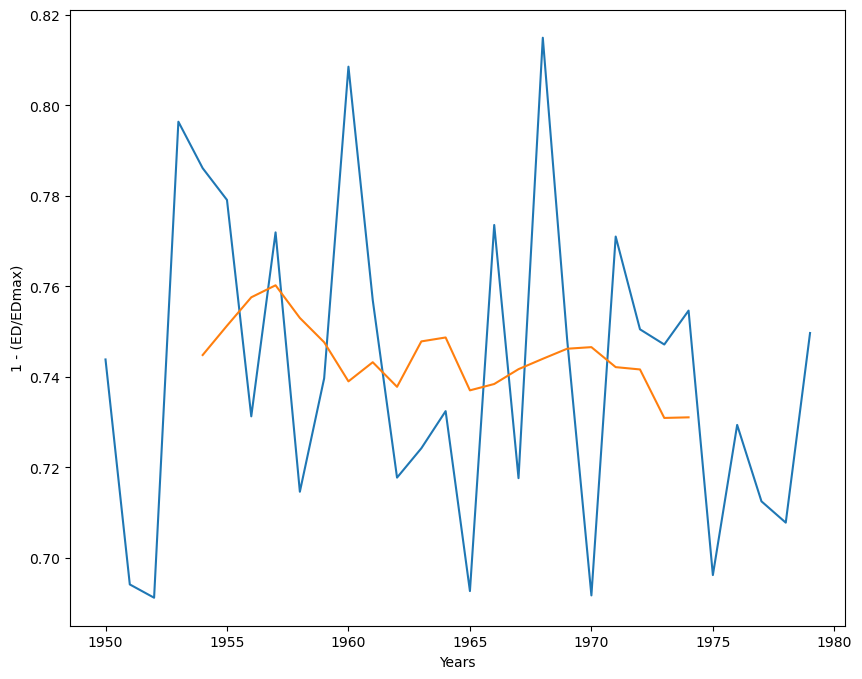

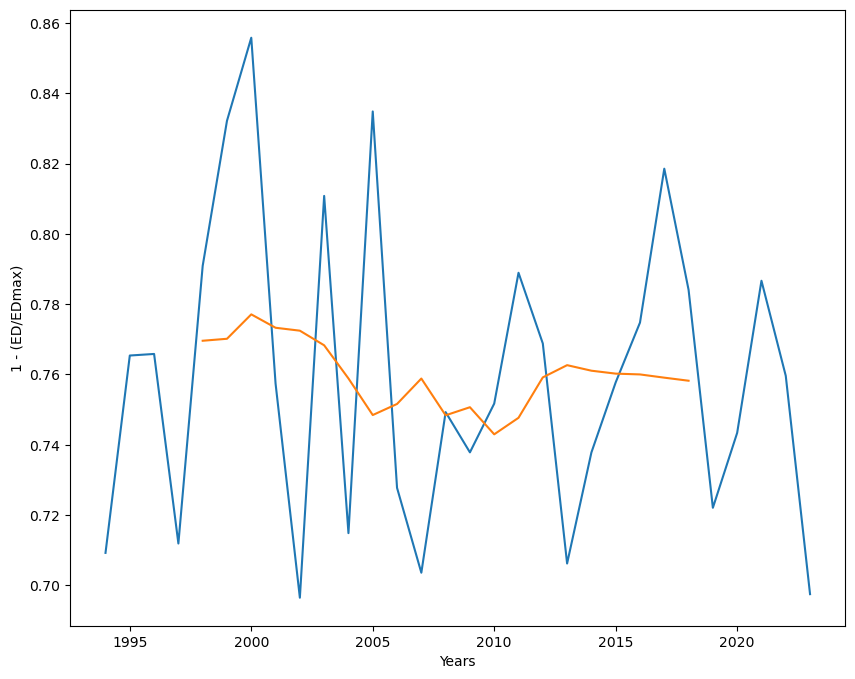

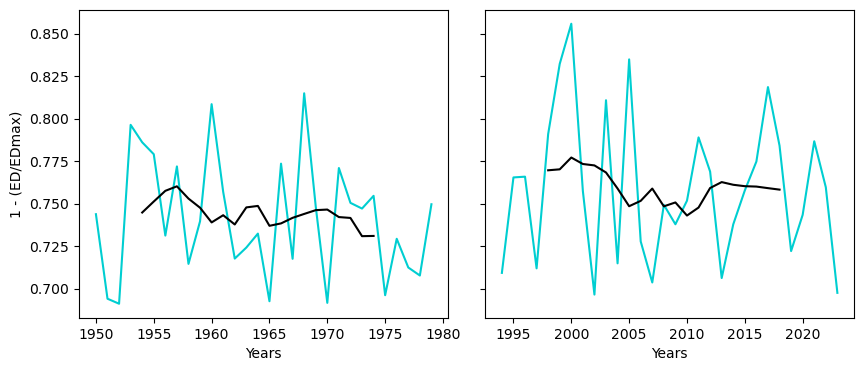

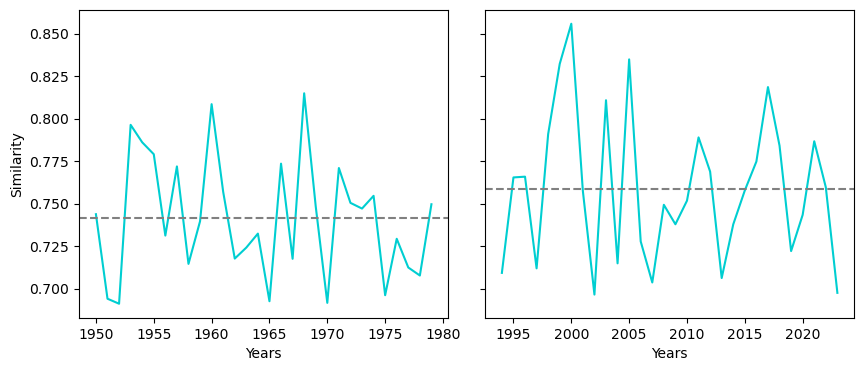

0.09508511187467142
0.23907300248018645
0.23907300248018645


In [56]:
#Extract the actual season for the trend plot and create trendplot (trend 2)
msl_box_season_filtered_p1,season_filtered_years_list_p1,season_filtered_months_list_p1 = extract_years_and_months_era5(msl_box,desired_start_monthV1,desired_end_monthV1,desired_start_yearV1,desired_end_yearV1,list_with_months, list_with_years)
msl_box_season_filtered_p2,season_filtered_years_list_p2,season_filtered_months_list_p2 = extract_years_and_months_era5(msl_box,desired_start_monthV2,desired_end_monthV2,desired_start_yearV2,desired_end_yearV2,list_with_months, list_with_years)
euclidian_distance_p1_season = euclidian_distance(msl_box_season_filtered_p1,event_box)
euclidian_distance_p2_season = euclidian_distance(msl_box_season_filtered_p2,event_box)
max_ed = find_max_for_trend(euclidian_distance_p1_season,euclidian_distance_p2_season)
min_euclidian_distances_p1 = yearly_minimum_euclidian_distance2(euclidian_distance_p1_season,filterd_yearlengthV,event_year,desired_start_yearV1,event_is_in_data=event_is_in_data_trendV1)
min_euclidian_distances_p2 = yearly_minimum_euclidian_distance2(euclidian_distance_p2_season,filterd_yearlengthV,event_year,desired_start_yearV2,event_is_in_data=event_is_in_data_trendV2)
trend_y_data_p1,trend_running_mean_data_p1 = plot_trend2(min_euclidian_distances_p1,euclidian_distance_p1_season,desired_start_yearV1,desired_end_yearV1,max_ed,"test","test",running_mean_window = running_mean_windowV)
trend_y_data_p2,trend_running_mean_data_p2 = plot_trend2(min_euclidian_distances_p2,euclidian_distance_p2_season,desired_start_yearV2,desired_end_yearV2,max_ed,"test","test",running_mean_window = running_mean_windowV)
plot_trend_combined_subplots(trend_y_data_p1,trend_y_data_p2,trend_running_mean_data_p1,trend_running_mean_data_p2,desired_start_yearV1,desired_start_yearV2,desired_end_yearV1,desired_end_yearV2,"test","test",running_mean_window = running_mean_windowV)
plot_trend_combined_subplots2(trend_y_data_p1,trend_y_data_p2,trend_running_mean_data_p1,trend_running_mean_data_p2,desired_start_yearV1,desired_start_yearV2,desired_end_yearV1,desired_end_yearV2,"test","test",running_mean_window = running_mean_windowV)
t_test_trend(trend_y_data_p1,trend_y_data_p2)
_, p_value_ks = ks_2samp(trend_y_data_p1, trend_y_data_p2)
print (p_value_ks)
_, p2 = scipy.stats.kstest(trend_y_data_p1, trend_y_data_p2)
print (p2)


Error: Amount of days in the data and list with all dates are not the same
Error: Amount of days in the data and list with all dates are not the same


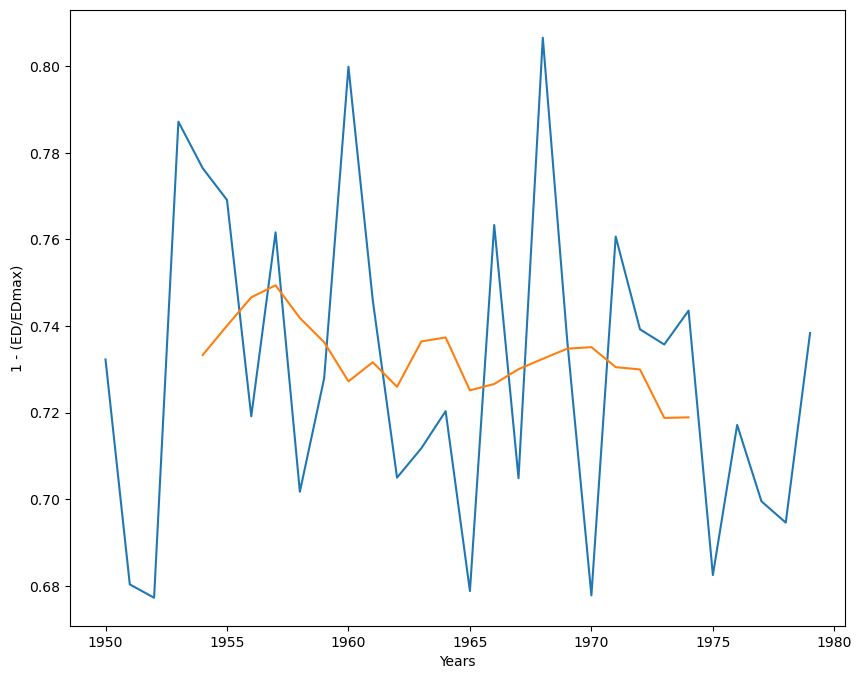

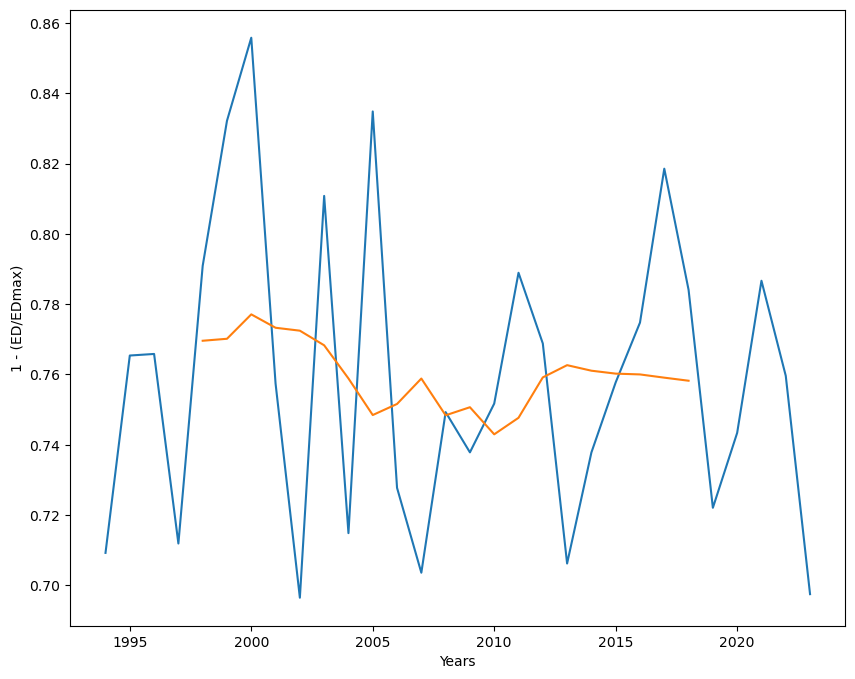

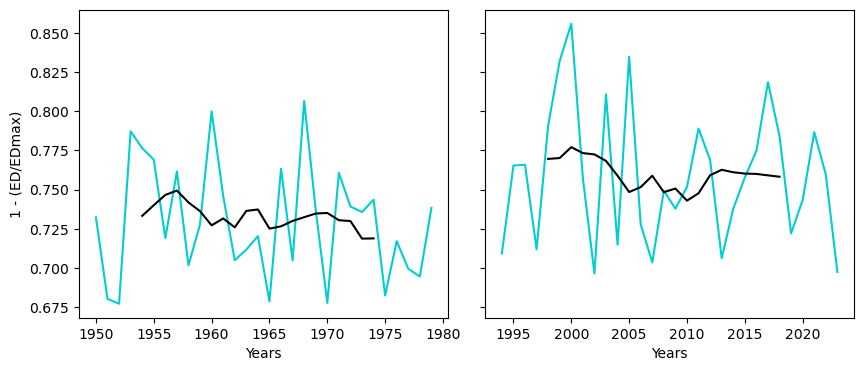

In [57]:
#Extract the actual season for the trend plot and create trendplot
msl_box_season_filtered_p1,season_filtered_years_list_p1,season_filtered_months_list_p1 = extract_years_and_months_era5(msl_box,desired_start_monthV1,desired_end_monthV1,desired_start_yearV1,desired_end_yearV1,list_with_months, list_with_years)
msl_box_season_filtered_p2,season_filtered_years_list_p2,season_filtered_months_list_p2 = extract_years_and_months_era5(msl_box,desired_start_monthV2,desired_end_monthV2,desired_start_yearV2,desired_end_yearV2,list_with_months, list_with_years)
euclidian_distance_p1_season = euclidian_distance(msl_box_season_filtered_p1,event_box)
euclidian_distance_p2_season = euclidian_distance(msl_box_season_filtered_p2,event_box)
min_euclidian_distances_p1 = yearly_minimum_euclidian_distance2(euclidian_distance_p1_season,filterd_yearlengthV,event_year,desired_start_yearV1,event_is_in_data=event_is_in_data_trendV1)
min_euclidian_distances_p2 = yearly_minimum_euclidian_distance2(euclidian_distance_p2_season,filterd_yearlengthV,event_year,desired_start_yearV2,event_is_in_data=event_is_in_data_trendV2)
trend_y_data_p1,trend_running_mean_data_p1 = plot_trend(min_euclidian_distances_p1,euclidian_distance_p1_season,desired_start_yearV1,desired_end_yearV1,"test","test",running_mean_window = running_mean_windowV)
trend_y_data_p2,trend_running_mean_data_p2 = plot_trend(min_euclidian_distances_p2,euclidian_distance_p2_season,desired_start_yearV2,desired_end_yearV2,"test","test",running_mean_window = running_mean_windowV)
plot_trend_combined_subplots(trend_y_data_p1,trend_y_data_p2,trend_running_mean_data_p1,trend_running_mean_data_p2,desired_start_yearV1,desired_start_yearV2,desired_end_yearV1,desired_end_yearV2,"test","test",running_mean_window = running_mean_windowV)

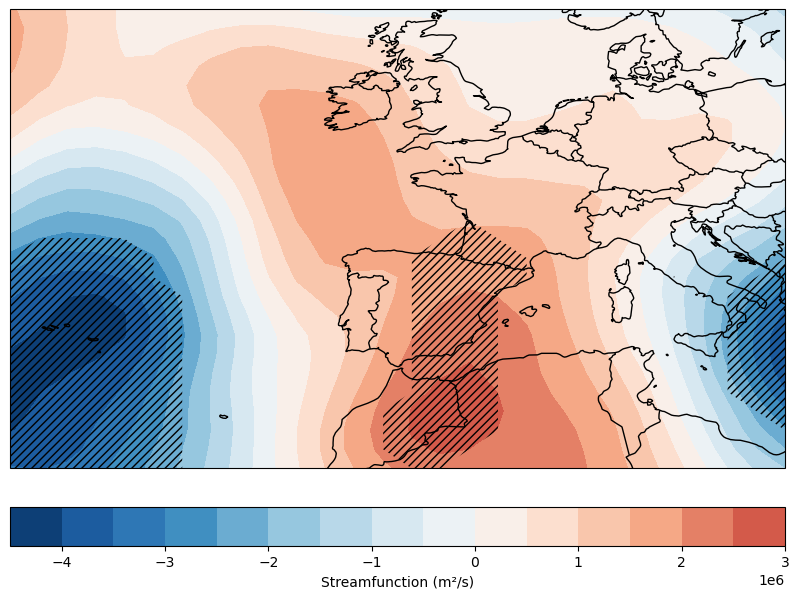

In [58]:
significance_map_difference = t_test(analogues_list_p1, analogues_list_p2,p_value_difference_mapsV)
plot_differencet_centeredt(lat_box,lon_box,pressure_difference_between_periods,significance_map_difference,"test","test")

In [3]:
# #Ook difference voor pressure
# lat_global_pressure,lon_global_pressure,pressure_global = load_data(data_path_pressure,"lat","lon","msl")
# lat_pressure_box, lon_pressure_box, pressure_box = extract_area(S1,N1,W1,E1,lat_global_pressure,lon_global_pressure,pressure_global, event = False)
# pressure_box_semi_filtered_p1,filtered_years_list_pressure_p1,filtered_months_list_pressure_p1 = extract_years_and_months_era5(pressure_box,1,12,desired_start_yearV1,desired_end_yearV1,list_with_months, list_with_years)
# pressure_box_semi_filtered_p2,filtered_years_list_pressure_p2,filtered_months_list_pressure_p2 = extract_years_and_months_era5(pressure_box,1,12,desired_start_yearV2,desired_end_yearV2,list_with_months, list_with_years)
# actual_pressure_difference_between_periods, mean_pressure_analogue_array_p1, mean_pressure_analogue_array_p2, pressure_analogues_array_p1, pressure_analogues_array_p2, pressure_analogues_list_p1, pressure_analogues_list_p2 = complete_and_mean_analogue_array(analogues_index_list_p1,pressure_box_semi_filtered_p1,analogues_index_list_p2,pressure_box_semi_filtered_p2)
# significance_map_difference_pressure = t_test(pressure_analogues_list_p1, pressure_analogues_list_p2,p_value_difference_mapsV)
# plot_differencet_centeredt(lat_pressure_box, lon_pressure_box,actual_pressure_difference_between_periods,significance_map_difference_pressure,"test","test")

# **Proberen**

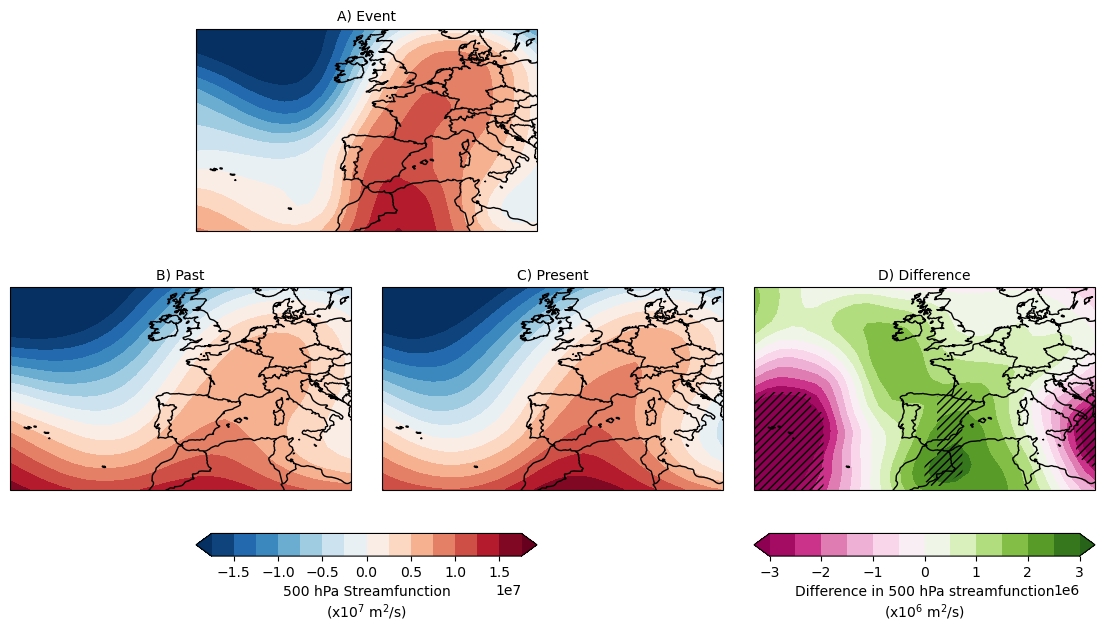

In [60]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize = (14,7))
gs = GridSpec(3, 6, figure=fig, height_ratios=[1, 1, 0.1], width_ratios=[1, 1,1,1,1,1])
#ax = plt.axes(projection = ccrs.PlateCarree())

levels1 = np.linspace(-1.75*1e7,1.75*1e7,15)
levels2 = np.linspace(-3*1e6,3*1e6,13)
ax1 = fig.add_subplot(gs[0, 1:3],projection=ccrs.PlateCarree())
contour1 = ax1.contourf(lon_box, lat_box, event_box[0], cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels1,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.set_title("A) Event",fontsize = 10)
#plt.colorbar(ax1, ax=ax1, orientation = "horizontal", label = "Pressure (Pa)", pad = 0.05)

ax2 = fig.add_subplot(gs[1, 0:2],projection=ccrs.PlateCarree())
contour1 = ax2.contourf(lon_box, lat_box, mean_analogue_array_p1, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels1,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.set_title("B) Past",fontsize = 10)

ax3 = fig.add_subplot(gs[1, 2:4],projection=ccrs.PlateCarree())
contour1 = ax3.contourf(lon_box, lat_box, mean_analogue_array_p2, cmap = "RdBu_r", transform = ccrs.PlateCarree(), levels = levels1,extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax3.coastlines()
ax3.add_feature(cf.BORDERS)
ax3.set_title("C) Present",fontsize = 10)

ax4 = fig.add_subplot(gs[1, 4:],projection=ccrs.PlateCarree())
contour2 = ax4.contourf(lon_box, lat_box, pressure_difference_between_periods, cmap = "PiYG", transform = ccrs.PlateCarree(), levels = levels2, extend = "both") #levels=np.linspace(-8.2e7, 1e7, 10), extend='both
ax4.contourf( lon_box, lat_box,significance_map_difference, levels=[-0.5,0.5,1.5], hatches=[None, '////'], colors='none', transform=ccrs.PlateCarree())
ax4.coastlines()
ax4.add_feature(cf.BORDERS)
ax4.set_title("D) Difference",fontsize = 10)


cax1 = fig.add_subplot(gs[2,1:3])
plt.colorbar(contour1, cax=cax1, orientation="horizontal", label="500 hPa Streamfunction\n(x$10^7$ m$^2$/s)")
formatter = ScalarFormatter(useMathText=True)
formatter.set_powerlimits((0, 0))  # Set the exponent limits
cax1.yaxis.set_major_formatter(formatter)

cax2 = fig.add_subplot(gs[2,4:])
plt.colorbar(contour2, cax=cax2, orientation="horizontal", label="Difference in 500 hPa streamfunction\n(x$10^6$ m$^2$/s)")
#plt.savefig("/usr/people/noest/stage_folders/outputs/figures_net/difference_test3_sig.png",dpi=600)
#plt.subplots_adjust(hspace=0.9)  # Change the value as needed
plt.show()
plt.close()